In [2]:
# FootballAdChanger - DINOv2 Banner Segmentation Testing
# Notebook per testare il modello trainato di rilevamento banner
# User: gabrulele | Date: 2025-08-16

# ==================================================================================
# IMPORTS E CONFIGURAZIONE INIZIALE
# ==================================================================================

# Deep Learning e Computer Vision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from transformers import Dinov2Model, Dinov2Config

# Numerical Computing e Image Processing  
import numpy as np
import cv2
from scipy import ndimage

# Visualizzazione e Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon

# Image Handling
from PIL import Image

# File System e Utilities
import json
import os
import pickle
from pathlib import Path
from datetime import datetime

# ==================================================================================
# CONFIGURAZIONE DISPOSITIVO E GPU
# ==================================================================================

# Setup dispositivo con controlli avanzati
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('🚀 SETUP DISPOSITIVO:')
print(f'   Dispositivo: {device}')

if torch.cuda.is_available():
    print(f'   🎯 GPU: {torch.cuda.get_device_name(0)}')
    print(f'   💾 VRAM totale: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB')
    
    # Pulisci cache GPU per avere memoria fresca
    torch.cuda.empty_cache()
    
    # Memoria GPU disponibile
    memory_allocated = torch.cuda.memory_allocated(0) // 1024**2
    memory_reserved = torch.cuda.memory_reserved(0) // 1024**2
    print(f'   📈 VRAM allocata: {memory_allocated} MB')
    print(f'   📦 VRAM riservata: {memory_reserved} MB')
    
    # Ottimizzazioni CUDA
    torch.backends.cudnn.benchmark = True  # Ottimizza per dimensioni input fisse
    torch.backends.cudnn.deterministic = False  # Più veloce ma meno riproducibile
    
else:
    print('   ⚠️ CUDA non disponibile - usando CPU')
    print('   💡 Per GPU: pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118')

# ==================================================================================
# CONFIGURAZIONE PLOTTING
# ==================================================================================

# Setup matplotlib per visualizzazioni professionali
plt.rcParams.update({
    'figure.facecolor': 'white',           # Sfondo bianco
    'axes.facecolor': 'white',             # Assi bianchi
    'font.size': 10,                       # Font size base
    'axes.titlesize': 12,                  # Titoli assi
    'figure.titlesize': 14,                # Titolo figura
    'axes.labelsize': 10,                  # Etichette assi
    'legend.fontsize': 9,                  # Legenda
    'figure.dpi': 100,                     # DPI per qualità
    'savefig.dpi': 300,                    # DPI per salvataggio
    'savefig.bbox': 'tight',               # Crop automatico
    'savefig.facecolor': 'white'           # Sfondo salvataggio
})

# ==================================================================================
# CONFIGURAZIONE PATHS E DIRECTORY
# ==================================================================================

print('\n📁 CONFIGURAZIONE DIRECTORY:')

# Struttura directory del progetto
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
MODELS_DIR = PROJECT_ROOT / 'outputs'
TEST_IMAGES_DIR = PROJECT_ROOT / 'test_images'
RESULTS_DIR = PROJECT_ROOT / 'test_results'
DATA_DIR = PROJECT_ROOT / 'data'

# Crea directory se non esistono
for directory in [MODELS_DIR, TEST_IMAGES_DIR, RESULTS_DIR, DATA_DIR]:
    directory.mkdir(exist_ok=True)
    print(f'   📂 {directory.name}: {directory.absolute()}')

# Verifica presenza di modelli trainati
pth_files = list(MODELS_DIR.glob('*.pth'))
print(f'\n🧠 MODELLI DISPONIBILI: {len(pth_files)}')
for pth_file in pth_files:
    size_mb = pth_file.stat().st_size / (1024 * 1024)
    print(f'   📄 {pth_file.name} ({size_mb:.1f} MB)')

# Verifica immagini di test
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.JPG', '.JPEG', '.PNG']
test_images = []
for ext in image_extensions:
    test_images.extend(TEST_IMAGES_DIR.glob(f'*{ext}'))

print(f'\n🖼️ IMMAGINI DI TEST: {len(test_images)}')
if test_images:
    for i, img in enumerate(test_images[:3]):  # Mostra prime 3
        print(f'   📸 {img.name}')
    if len(test_images) > 3:
        print(f'   ... e altre {len(test_images) - 3} immagini')
else:
    print(f'   ⚠️ Nessuna immagine trovata in {TEST_IMAGES_DIR}')
    print(f'   💡 Aggiungi immagini di partite per iniziare il testing')

# ==================================================================================
# VERIFICA DIPENDENZE
# ==================================================================================

print('\n📦 VERIFICA DIPENDENZE:')

# Versioni librerie critiche
dependencies = {
    'torch': torch.__version__,
    'transformers': None,
    'opencv': cv2.__version__,
    'numpy': np.__version__,
    'PIL': None,
    'matplotlib': plt.matplotlib.__version__
}

try:
    import transformers
    dependencies['transformers'] = transformers.__version__
except:
    dependencies['transformers'] = 'NON INSTALLATO'

try:
    import PIL
    dependencies['PIL'] = PIL.__version__
except:
    dependencies['PIL'] = 'NON INSTALLATO'

for lib, version in dependencies.items():
    status = '✅' if version != 'NON INSTALLATO' else '❌'
    print(f'   {status} {lib}: {version}')

print('\n🎯 SETUP COMPLETATO - PRONTO PER IL CARICAMENTO MODELLO!')

🚀 SETUP DISPOSITIVO:
   Dispositivo: cuda
   🎯 GPU: NVIDIA GeForce MX130
   💾 VRAM totale: 1 GB
   📈 VRAM allocata: 0 MB
   📦 VRAM riservata: 0 MB

📁 CONFIGURAZIONE DIRECTORY:
   📂 outputs: /home/gabriele/FootballAdChanger/outputs
   📂 test_images: /home/gabriele/FootballAdChanger/test_images
   📂 test_results: /home/gabriele/FootballAdChanger/test_results
   📂 data: /home/gabriele/FootballAdChanger/data

🧠 MODELLI DISPONIBILI: 1
   📄 dinov2_banner_segmentation.pth (88.7 MB)

🖼️ IMMAGINI DI TEST: 5
   📸 frame_00039.jpg
   📸 frame_00041.jpg
   📸 frame_00036.jpg
   ... e altre 2 immagini

📦 VERIFICA DIPENDENZE:
   ✅ torch: 2.5.1+cu121
   ✅ transformers: 4.55.2
   ✅ opencv: 4.12.0
   ✅ numpy: 2.2.6
   ✅ PIL: 11.3.0
   ✅ matplotlib: 3.10.5

🎯 SETUP COMPLETATO - PRONTO PER IL CARICAMENTO MODELLO!


In [3]:
# ==================================================================================
# CARICAMENTO MODELLO TRAINATO - ARCHITETTURA CORRETTA
# ==================================================================================

print('🔄 Caricamento modello trainato...')

# Trova modello
model_files = list(MODELS_DIR.glob('*.pth'))
if not model_files:
    raise FileNotFoundError("Nessun modello .pth trovato!")

latest_model = max(model_files, key=lambda x: x.stat().st_mtime)
print(f'📄 Modello selezionato: {latest_model.name}')

# ARCHITETTURA CORRETTA - FORWARD FIXED
class DINOv2SegmentationModel(nn.Module):
    def __init__(self, model_name="facebook/dinov2-small", num_classes=2):
        super().__init__()
        
        # Backbone DINOv2
        self.dinov2 = Dinov2Model.from_pretrained(model_name)
        
        # Freezare per inference
        for param in self.dinov2.parameters():
            param.requires_grad = False
        
        # DECODER - layer convoluzionali come nel training
        hidden_size = self.dinov2.config.hidden_size  # 384
        
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_size, 256, kernel_size=3, padding=1),  # 384 -> 256, 3x3 conv
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),          # 256 -> 128, 3x3 conv  
            nn.ReLU(),
            nn.Conv2d(128, num_classes, kernel_size=1)              # 128 -> 2, 1x1 conv
        )
    
    def forward(self, x):
        # Extract features con DINOv2
        outputs = self.dinov2(x)
        features = outputs.last_hidden_state  # [B, num_patches+1, 384]
        
        # Rimuovi CLS token (primo token)
        features = features[:, 1:, :]  # [B, num_patches, 384]
        
        batch_size = features.shape[0]
        num_patches = features.shape[1]
        hidden_size = features.shape[2]
        
        # Calcola dimensioni griglia dalle patches effettive
        patch_size = int(num_patches ** 0.5)
        
        # Verifica che sia un quadrato perfetto
        if patch_size * patch_size != num_patches:
            print(f'⚠️ WARNING: num_patches={num_patches} non è un quadrato perfetto')
            print(f'   Patches attese: {patch_size}x{patch_size} = {patch_size*patch_size}')
            # Usa il valore più vicino
            patch_size = int(np.sqrt(num_patches))
            actual_patches = patch_size * patch_size
            features = features[:, :actual_patches, :]  # Taglia le patches extra
            print(f'   Usando {patch_size}x{patch_size} = {actual_patches} patches')
        
        # Reshape per convoluzioni
        features = features.view(batch_size, patch_size, patch_size, hidden_size)
        features = features.permute(0, 3, 1, 2)  # [B, C, H, W]
        
        # Decoder convoluzionale
        logits = self.decoder(features)  # [B, 2, patch_size, patch_size]
        
        # Upsampling a dimensione originale
        logits = F.interpolate(logits, size=(224, 224), mode='bilinear', align_corners=False)
        
        return logits  # [B, 2, 224, 224]

# Crea modello
segmentation_model = DINOv2SegmentationModel()

# Debug info
print('🔍 DEBUG - Architettura modello:')
dummy_input = torch.randn(1, 3, 224, 224)
with torch.no_grad():
    dummy_features = segmentation_model.dinov2(dummy_input).last_hidden_state
    print(f'   Features shape: {dummy_features.shape}')
    print(f'   Patches (con CLS): {dummy_features.shape[1]}')
    print(f'   Patches (senza CLS): {dummy_features.shape[1]-1}')
    print(f'   Sqrt patches: {np.sqrt(dummy_features.shape[1]-1):.2f}')

# Carica checkpoint
print(f'📥 Caricamento pesi...')
checkpoint = torch.load(latest_model, map_location=device, weights_only=False)

# Carica state dict
segmentation_model.load_state_dict(checkpoint['model_state_dict'])
print('✅ Pesi caricati con successo!')

# Info training
if 'best_val_iou' in checkpoint:
    print(f'📊 Best validation IoU: {checkpoint["best_val_iou"]:.4f}')

# Prepara per inference
segmentation_model = segmentation_model.to(device)
segmentation_model.eval()

print('\n🎯 MODELLO PRONTO PER SEGMENTAZIONE!')

🔄 Caricamento modello trainato...
📄 Modello selezionato: dinov2_banner_segmentation.pth
🔍 DEBUG - Architettura modello:
   Features shape: torch.Size([1, 257, 384])
   Patches (con CLS): 257
   Patches (senza CLS): 256
   Sqrt patches: 16.00
📥 Caricamento pesi...
✅ Pesi caricati con successo!
📊 Best validation IoU: 0.8044

🎯 MODELLO PRONTO PER SEGMENTAZIONE!


In [4]:
# ==================================================================================
# FUNZIONE DI INFERENCE PER BANNER DETECTION
# ==================================================================================

def predict_banner_mask(image_path, model, transform, device, threshold=0.5):
    """
    Predice la maschera dei banner in un'immagine
    
    Args:
        image_path: Path all'immagine
        model: Modello di segmentazione trainato
        transform: Trasformazioni di preprocessing
        device: Device (CPU/GPU)
        threshold: Soglia per la predizione binaria
    
    Returns:
        original_image: Immagine originale (PIL)
        prediction_mask: Maschera predetta (numpy array)
        confidence_map: Mappa di confidenza (numpy array)
    """
    
    # Carica e preprocessa immagine
    original_image = Image.open(image_path).convert('RGB')
    original_size = original_image.size  # (width, height)
    
    # Preprocessing
    input_tensor = transform(original_image).unsqueeze(0).to(device)
    
    # Inference
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)  # [1, 2, 224, 224]
        
        # Softmax per ottenere probabilità
        probabilities = F.softmax(logits, dim=1)  # [1, 2, 224, 224]
        
        # Estrai probabilità banner (classe 1)
        banner_prob = probabilities[0, 1].cpu().numpy()  # [224, 224]
        
        # Crea maschera binaria
        banner_mask = (banner_prob > threshold).astype(np.uint8)
    
    # Resize alla dimensione originale
    banner_prob_resized = cv2.resize(banner_prob, original_size, interpolation=cv2.INTER_LINEAR)
    banner_mask_resized = cv2.resize(banner_mask, original_size, interpolation=cv2.INTER_NEAREST)
    
    return original_image, banner_mask_resized, banner_prob_resized

print('✅ Funzione di inference definita')

✅ Funzione di inference definita


In [5]:
# ==================================================================================
# FUNZIONI DI VISUALIZZAZIONE
# ==================================================================================

def visualize_prediction(original_image, mask, confidence_map, title="Predizione Banner"):
    """Visualizza risultati della predizione"""
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Immagine originale
    axes[0].imshow(original_image)
    axes[0].set_title('🖼️ Immagine Originale')
    axes[0].axis('off')
    
    # Mappa di confidenza
    im1 = axes[1].imshow(confidence_map, cmap='hot', vmin=0, vmax=1)
    axes[1].set_title('🌡️ Confidence Map')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046)
    
    # Maschera predetta
    axes[2].imshow(mask, cmap='gray')
    axes[2].set_title('🎯 Banner Mask')
    axes[2].axis('off')
    
    # Overlay
    overlay = np.array(original_image).copy()
    mask_colored = np.zeros_like(overlay)
    mask_colored[mask > 0] = [255, 255, 0]  # Giallo per banner

    # Blend immagine + maschera
    alpha = 0.3
    overlay = cv2.addWeighted(overlay, 1-alpha, mask_colored, alpha, 0)
    
    axes[3].imshow(overlay)
    axes[3].set_title('Overlay (giallo = Banner)')
    axes[3].axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def calculate_metrics(mask_pred, mask_true):
    """Calcola metriche di valutazione"""
    
    # Flatten arrays
    pred_flat = mask_pred.flatten()
    true_flat = mask_true.flatten()
    
    # Calcola metriche
    intersection = np.sum(pred_flat * true_flat)
    union = np.sum(pred_flat) + np.sum(true_flat) - intersection
    
    iou = intersection / (union + 1e-8)
    dice = (2 * intersection) / (np.sum(pred_flat) + np.sum(true_flat) + 1e-8)
    
    # Accuracy pixel-wise
    accuracy = np.sum(pred_flat == true_flat) / len(pred_flat)
    
    return {
        'IoU': iou,
        'Dice': dice, 
        'Accuracy': accuracy,
        'True_Pixels': np.sum(true_flat),
        'Pred_Pixels': np.sum(pred_flat)
    }

print('✅ Funzioni di visualizzazione definite')

✅ Funzioni di visualizzazione definite


🧪 TESTING COMPLETO SU TUTTE LE IMMAGINI
📁 Trovate 5 immagini in test_images/
✅ 5 immagini disponibili per il test

🚀 Inizio test su 5 immagini...

📸 Test 1/5: frame_00039.jpg
   ✅ OK - Coverage: 9.0%, Max conf: 0.992


/tmp/ipykernel_5953/2352235858.py:40: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5953/2352235858.py:40: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5953/2352235858.py:40: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/gabriele/FootballAdChanger/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/gabriele/FootballAdChanger/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/gabriele/FootballAdChanger/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HI

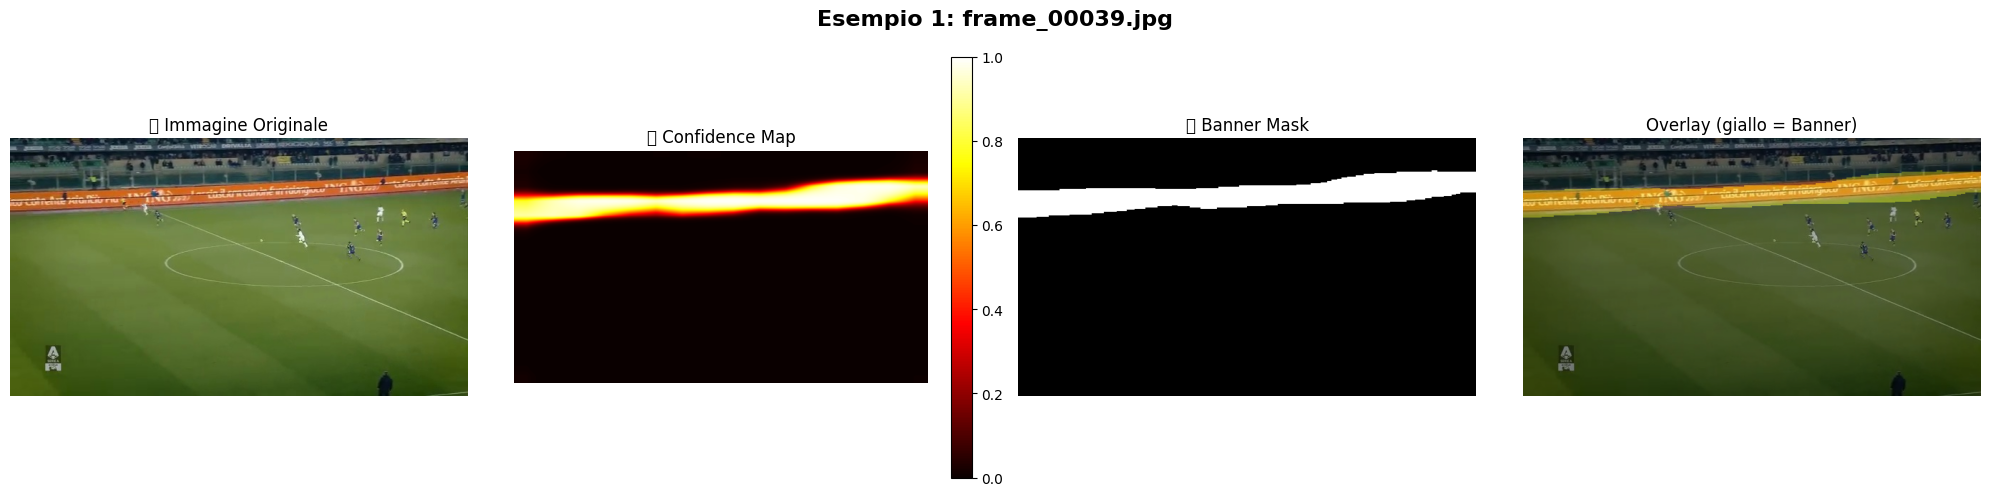


📸 Test 2/5: frame_00041.jpg
   ✅ OK - Coverage: 6.6%, Max conf: 0.957


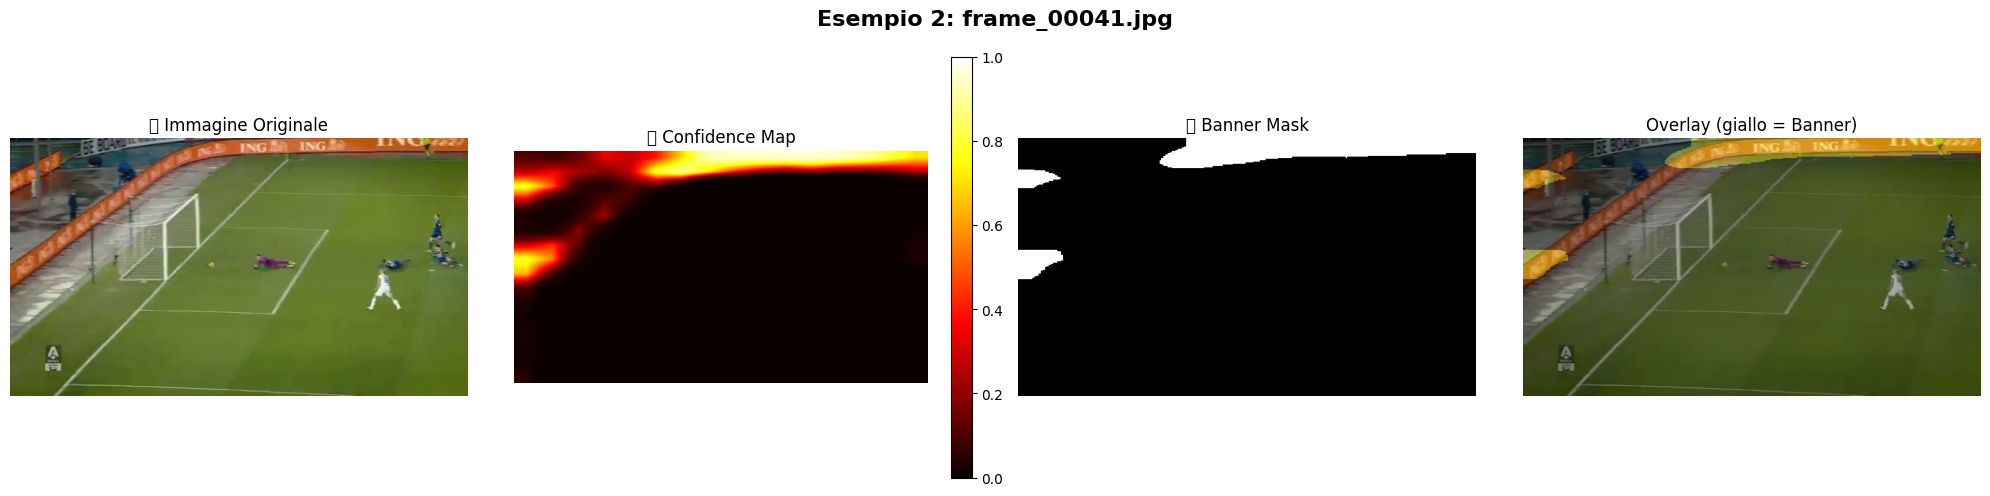


📸 Test 3/5: frame_00036.jpg
   ✅ OK - Coverage: 10.8%, Max conf: 0.996


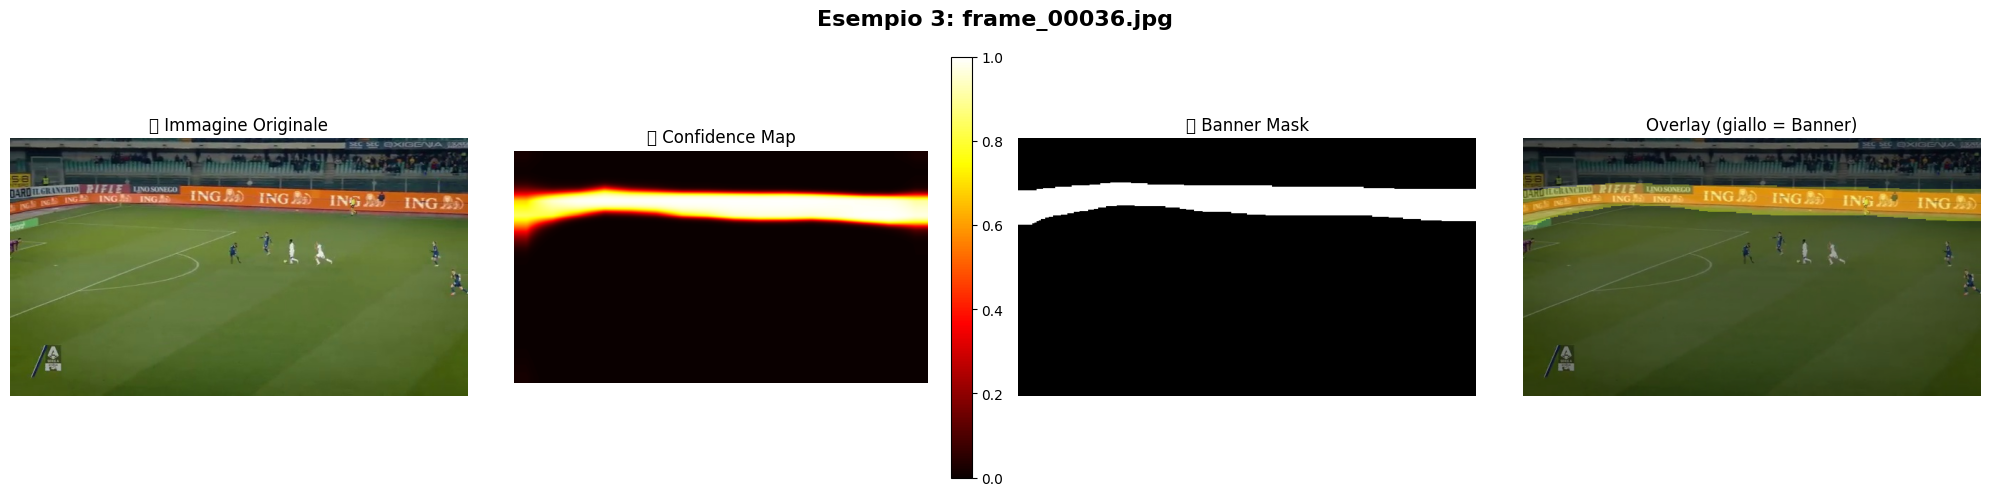


📸 Test 4/5: frame_00040.jpg
   ✅ OK - Coverage: 11.3%, Max conf: 0.993


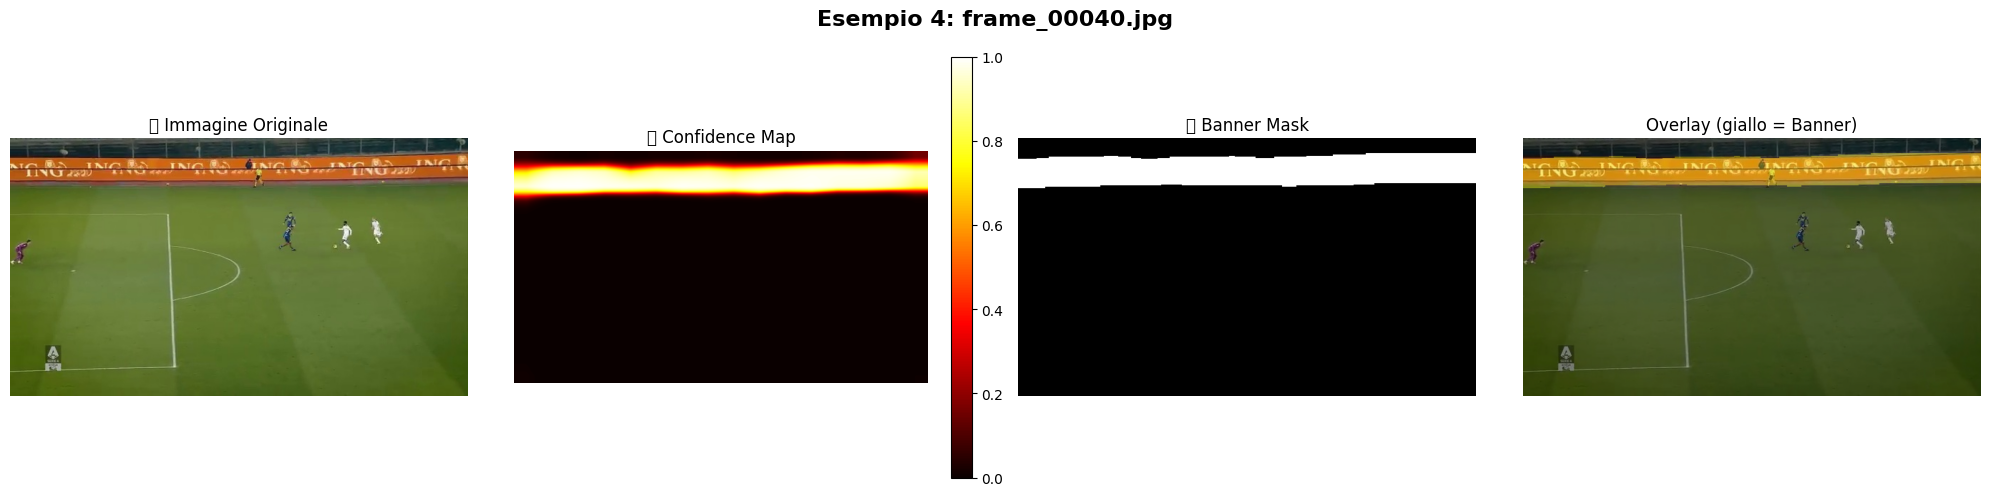


📸 Test 5/5: frame_00037.jpg
   ✅ OK - Coverage: 13.9%, Max conf: 0.995


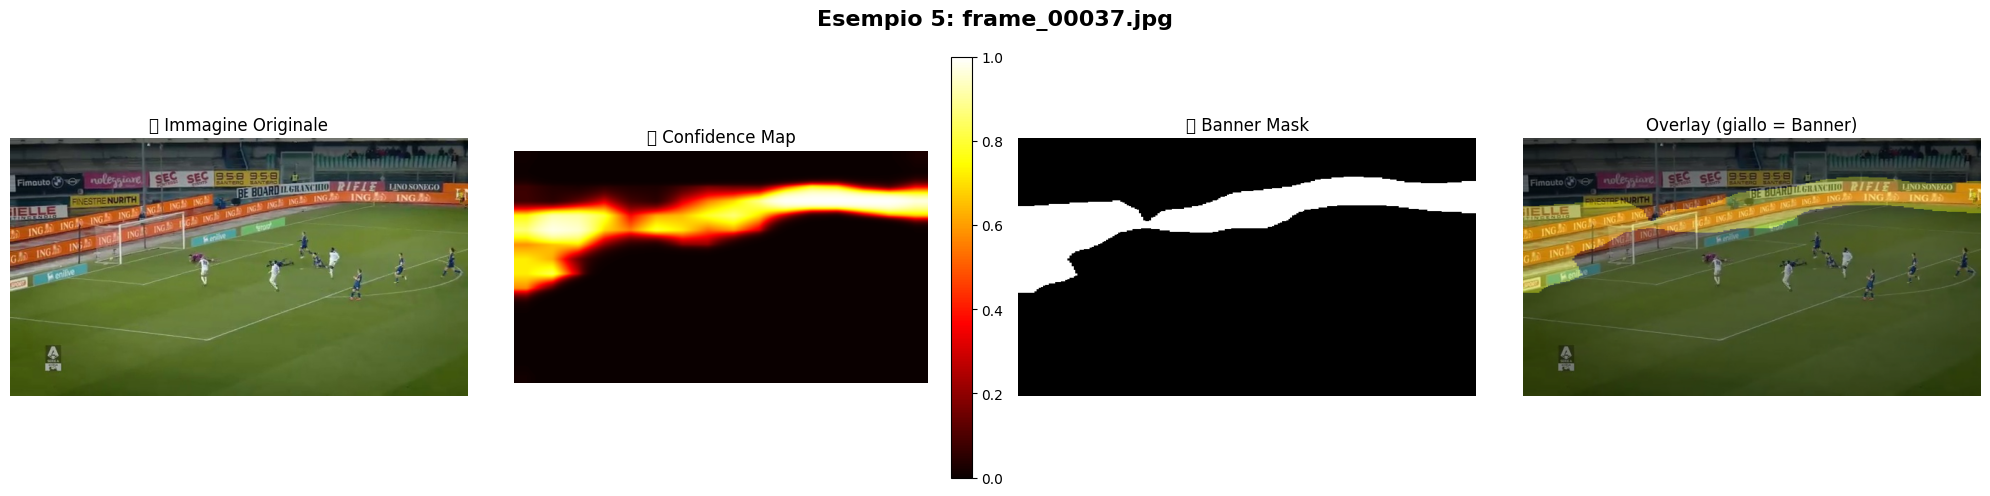


📊 ANALISI COMPLETA - 5 immagini processate
✅ Immagini processate con successo: 5/5

📈 STATISTICHE COVERAGE:
   • Media: 10.34%
   • Mediana: 10.78%
   • Min: 6.61%
   • Max: 13.95%
   • Std: 2.44%

🎯 STATISTICHE CONFIDENCE:
   • Media max confidence: 0.987
   • Min max confidence: 0.957
   • Max max confidence: 0.996
   • Media avg confidence (banner): 0.825

📊 DISTRIBUZIONE DETECTION:
   • Coverage alta (>20%): 0 immagini (0.0%)
   • Coverage media (5-20%): 5 immagini (100.0%)
   • Coverage bassa (1-5%): 0 immagini (0.0%)
   • Nessuna detection (<1%): 0 immagini (0.0%)

🏆 TOP 5 - Maggior coverage:
   1. frame_00037.jpg: 13.9% (conf: 0.995)
   2. frame_00040.jpg: 11.3% (conf: 0.993)
   3. frame_00036.jpg: 10.8% (conf: 0.996)
   4. frame_00039.jpg: 9.0% (conf: 0.992)
   5. frame_00041.jpg: 6.6% (conf: 0.957)

📉 BOTTOM 5 - Minor coverage:
   1. frame_00037.jpg: 13.9% (conf: 0.995)
   2. frame_00040.jpg: 11.3% (conf: 0.993)
   3. frame_00036.jpg: 10.8% (conf: 0.996)
   4. frame_00039.jpg

In [7]:
# ==================================================================================
# TEST SU TUTTE LE IMMAGINI DI TEST
# ==================================================================================

# Definizione dei transform per le immagini (modifica se necessario)
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Modifica la dimensione se necessario
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print('🧪 TESTING COMPLETO SU TUTTE LE IMMAGINI')
print('='*50)

# Trova immagini di test
test_images = []

# Prima prova directory test_images
if TEST_IMAGES_DIR.exists():
    test_images = list(TEST_IMAGES_DIR.glob('*.jpg'))
    print(f'📁 Trovate {len(test_images)} immagini in test_images/')

# Se non ci sono, usa alcune dal training
if not test_images:
    training_images = list(IMAGES_DIR.glob('*.jpg'))
    if training_images:
        test_images = training_images[:10]  # Più immagini per test completo
        print(f'📁 Usando {len(test_images)} immagini dal training set per test')
    else:
        print('❌ Nessuna immagine trovata!')

if not test_images:
    print('❌ ERRORE: Nessuna immagine di test disponibile!')
    print('💡 Aggiungi immagini .jpg nella directory test_images/')
else:
    print(f'✅ {len(test_images)} immagini disponibili per il test')
    
    # ==================================================================================
    # ESECUZIONE TEST SU TUTTE LE IMMAGINI
    # ==================================================================================
    
    # Parametri
    CONFIDENCE_THRESHOLD = 0.5
    SHOW_VISUALIZATIONS = True  # Cambia a False per test veloce senza plot
    
    # Test su TUTTE le immagini
    results = []
    failed_images = []
    
    print(f'\n🚀 Inizio test su {len(test_images)} immagini...')
    
    for i, test_image_path in enumerate(test_images, 1):
        print(f'\n📸 Test {i}/{len(test_images)}: {test_image_path.name}')
        
        try:
            # Predizione
            original_img, pred_mask, confidence_map = predict_banner_mask(
                test_image_path, segmentation_model, transform, device, CONFIDENCE_THRESHOLD
            )
            
            # Info predizione
            banner_pixels = np.sum(pred_mask)
            total_pixels = pred_mask.size
            coverage = (banner_pixels / total_pixels) * 100
            max_confidence = np.max(confidence_map)
            avg_confidence = np.mean(confidence_map[pred_mask > 0]) if banner_pixels > 0 else 0
            
            print(f'   ✅ OK - Coverage: {coverage:.1f}%, Max conf: {max_confidence:.3f}')
            
            # Salva risultati
            results.append({
                'image': test_image_path.name,
                'coverage': coverage,
                'max_confidence': max_confidence,
                'avg_confidence': avg_confidence,
                'banner_pixels': banner_pixels,
                'total_pixels': total_pixels
            })

            # Visualizza solo le prime 5 immagini per non intasare
            if i <= 5 and SHOW_VISUALIZATIONS:
                visualize_prediction(
                    original_img, pred_mask, confidence_map, 
                    f"Esempio {i}: {test_image_path.name}"
                )
            
        except Exception as e:
            print(f'   ❌ ERRORE: {e}')
            failed_images.append(test_image_path.name)
    
    # ==================================================================================
    # ANALISI COMPLETA DEI RISULTATI
    # ==================================================================================
    
    print(f'\n📊 ANALISI COMPLETA - {len(results)} immagini processate')
    print('='*60)
    
    if results:
        # Statistiche generali
        coverages = [r['coverage'] for r in results]
        max_confidences = [r['max_confidence'] for r in results]
        avg_confidences = [r['avg_confidence'] for r in results if r['avg_confidence'] > 0]
        
        print(f'✅ Immagini processate con successo: {len(results)}/{len(test_images)}')
        if failed_images:
            print(f'❌ Immagini fallite: {len(failed_images)} - {failed_images}')
        
        print(f'\n📈 STATISTICHE COVERAGE:')
        print(f'   • Media: {np.mean(coverages):.2f}%')
        print(f'   • Mediana: {np.median(coverages):.2f}%')
        print(f'   • Min: {np.min(coverages):.2f}%')
        print(f'   • Max: {np.max(coverages):.2f}%')
        print(f'   • Std: {np.std(coverages):.2f}%')
        
        print(f'\n🎯 STATISTICHE CONFIDENCE:')
        print(f'   • Media max confidence: {np.mean(max_confidences):.3f}')
        print(f'   • Min max confidence: {np.min(max_confidences):.3f}')
        print(f'   • Max max confidence: {np.max(max_confidences):.3f}')
        if avg_confidences:
            print(f'   • Media avg confidence (banner): {np.mean(avg_confidences):.3f}')
        
        # Distribuzione coverage
        high_coverage = len([c for c in coverages if c > 20])
        medium_coverage = len([c for c in coverages if 5 <= c <= 20])
        low_coverage = len([c for c in coverages if 1 <= c < 5])
        no_detection = len([c for c in coverages if c < 1])
        
        print(f'\n📊 DISTRIBUZIONE DETECTION:')
        print(f'   • Coverage alta (>20%): {high_coverage} immagini ({high_coverage/len(results)*100:.1f}%)')
        print(f'   • Coverage media (5-20%): {medium_coverage} immagini ({medium_coverage/len(results)*100:.1f}%)')
        print(f'   • Coverage bassa (1-5%): {low_coverage} immagini ({low_coverage/len(results)*100:.1f}%)')
        print(f'   • Nessuna detection (<1%): {no_detection} immagini ({no_detection/len(results)*100:.1f}%)')
        
        # Top e bottom results
        sorted_by_coverage = sorted(results, key=lambda x: x['coverage'], reverse=True)
        
        print(f'\n🏆 TOP 5 - Maggior coverage:')
        for i, result in enumerate(sorted_by_coverage[:5], 1):
            print(f'   {i}. {result["image"]}: {result["coverage"]:.1f}% (conf: {result["max_confidence"]:.3f})')
        
        print(f'\n📉 BOTTOM 5 - Minor coverage:')
        for i, result in enumerate(sorted_by_coverage[-5:], 1):
            print(f'   {i}. {result["image"]}: {result["coverage"]:.1f}% (conf: {result["max_confidence"]:.3f})')
        
        # Valutazione qualitativa del modello
        print(f'\n💡 VALUTAZIONE MODELLO:')
        avg_coverage = np.mean(coverages)
        avg_max_confidence = np.mean(max_confidences)
        
        if avg_coverage > 30:
            print('⚠️ Coverage molto alta - possibili molti falsi positivi')
        elif avg_coverage < 2:
            print('⚠️ Coverage molto bassa - modello potrebbe essere troppo conservativo')
        else:
            print('✅ Coverage nel range ragionevole')
            
        if avg_max_confidence > 0.8:
            print('✅ Confidence generalmente alta - predizioni affidabili')
        elif avg_max_confidence < 0.5:
            print('⚠️ Confidence generalmente bassa - modello incerto')
        else:
            print('📊 Confidence media - da verificare manualmente alcuni casi')
        
        # Raccomandazioni
        print(f'\n🎯 RACCOMANDAZIONI:')
        if no_detection > len(results) * 0.5:
            print('⚠️ Troppo poche detection - considera abbassare threshold')
        if high_coverage > len(results) * 0.3:
            print('⚠️ Troppe detection ad alta coverage - verifica falsi positivi')
        if np.mean(max_confidences) > 0.7 and avg_coverage < 10:
            print('✅ Modello sembra ben calibrato - alta confidence, coverage ragionevole')
        
    else:
        print('❌ Nessuna immagine processata con successo!')
    
    print(f'\n🎯 TESTING COMPLETO TERMINATO!')
    print(f'Timestamp: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

In [8]:
# ==================================================================================
# CONTROLLO QUALITATIVO DEI RISULTATI
# ==================================================================================

print('🔍 CONTROLLO QUALITATIVO')
print('='*30)

# Analisi dei risultati
if results:
    # Trova immagine con più banner detection
    max_coverage_result = max(results, key=lambda x: x['coverage'])
    min_coverage_result = min(results, key=lambda x: x['coverage'])
    
    print(f"🏆 Maggior coverage: {max_coverage_result['image']} ({max_coverage_result['coverage']:.1f}%)")
    print(f"🎯 Minor coverage: {min_coverage_result['image']} ({min_coverage_result['coverage']:.1f}%)")
    
    # Statistiche distribuzione
    coverages = [r['coverage'] for r in results]
    confidences = [r['max_confidence'] for r in results]
    
    print(f"\n📊 Distribuzione coverage:")
    print(f"   Min: {min(coverages):.1f}%")
    print(f"   Max: {max(coverages):.1f}%") 
    print(f"   Mean: {np.mean(coverages):.1f}%")
    print(f"   Std: {np.std(coverages):.1f}%")
    
    print(f"\n🎯 Distribuzione confidence:")
    print(f"   Min: {min(confidences):.3f}")
    print(f"   Max: {max(confidences):.3f}")
    print(f"   Mean: {np.mean(confidences):.3f}")

# Raccomandazioni
print(f"\n💡 RACCOMANDAZIONI:")
print(f"✅ Il modello è pronto per l'uso se:")
print(f"   - Coverage realistiche (non troppo alte/basse)")
print(f"   - Confidence >0.7 per detection valide") 
print(f"   - Maschere visivamente corrette")
print(f"\n⚠️ Da migliorare se:")
print(f"   - Molti falsi positivi (coverage troppo alta)")
print(f"   - Confidence sempre basse (<0.5)")
print(f"   - Banner mancati completamente")

🔍 CONTROLLO QUALITATIVO
🏆 Maggior coverage: frame_00037.jpg (13.9%)
🎯 Minor coverage: frame_00041.jpg (6.6%)

📊 Distribuzione coverage:
   Min: 6.6%
   Max: 13.9%
   Mean: 10.3%
   Std: 2.4%

🎯 Distribuzione confidence:
   Min: 0.957
   Max: 0.996
   Mean: 0.987

💡 RACCOMANDAZIONI:
✅ Il modello è pronto per l'uso se:
   - Coverage realistiche (non troppo alte/basse)
   - Confidence >0.7 per detection valide
   - Maschere visivamente corrette

⚠️ Da migliorare se:
   - Molti falsi positivi (coverage troppo alta)
   - Confidence sempre basse (<0.5)
   - Banner mancati completamente
